# Model selection and evaluation

__Notes__

1. Create set of rules for what reviews to accept or throw out
    1. Min or max number of words
    1. Include URLs or not
    1. Emojis
    1. Eliminate stop words
    
1. Model selection
    1. CNN for usefulness
    1. Sample from useful reviews only
    1. Setup T5 transfering learning model to generate "justification" text

- LSTM is good
    - You can add in an attention layer because it can look backwards and learn what words were more important than others
- CNN is good for sentence classification 
    - With a fully connected Dense layer it is not good at generalizing
- BERT is good because of its self-attention mechanism where every word looks at every other layer
    - Use the CLS token as the only thing you feed into the output layer that is going to make the prediction on the classification

## 0.0 Notebook setup

### X.X Colab Setup

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

In [ ]:
! mkdir data

In [ ]:
! cp "/content/gdrive/My Drive/nlp-book-reviews/data/electronics.csv" ./data/

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [ ]:
!pip install --quiet transformers

### X.X Local setup

In [1]:
import warnings

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", DeprecationWarning)

In [74]:
# Statistics
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, norm, skew, kurtosis

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_curve, auc, accuracy_score

# Model building
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, Dense, Flatten, LSTM, Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# BERT-specific
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

In [240]:
# Local
data = '../data/electronics.csv'

# Colab
# data = './data/electronics.csv'

review_samples = pd.read_csv(data)

In [241]:
# Create sentiment axis label for plots
sentiment = ['Not Useful', 'Useful']

# Check split of useful / not useful
review_samples['useful'].value_counts()

1    732
0    506
Name: useful, dtype: int64

## X.X Usefulness language modeling

### X.X Baseline - Naive Bayes

In [242]:
reviews = review_samples['review_processed'].fillna('no review')
labels = review_samples['useful'].astype(int)

In [243]:
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.2, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)

X_train_tfidf = tf_idf.fit_transform(X_train)
X_dev_tfidf = tf_idf.transform(X_dev)
X_test_tfidf = tf_idf.transform(X_test)

In [244]:
# Build model
nb_model = MultinomialNB(alpha=1.8)

# Fit model
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=1.8)

In [245]:
# Evaluate model on dev data
train_acc = nb_model.score(X_train_tfidf, y_train)
dev_acc = nb_model.score(X_dev_tfidf, y_dev)
test_acc = nb_model.score(X_test_tfidf, y_test)

print(train_acc, dev_acc, test_acc)

0.862533692722372 0.5725806451612904 0.6048387096774194


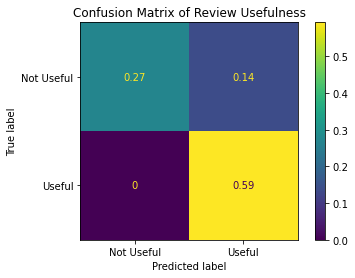

In [246]:
# Evaluate model on test data and plot confusion matrix
y_true = y_train
y_pred = nb_model.predict(X_train_tfidf)

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

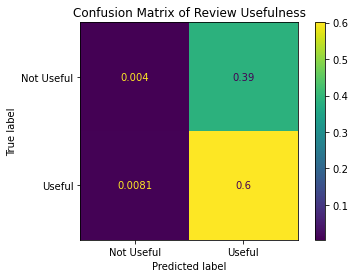

In [247]:
# Evaluate model on test data and plot confusion matrix
y_true = y_test
y_pred = nb_model.predict(X_test_tfidf)

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

AUC: 0.4985


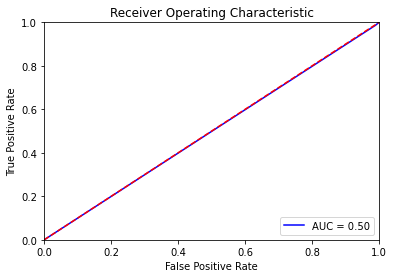

In [248]:
fpr, tpr, threshold = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')

# Plot ROC AUC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## X.X Tokenization and analytics

In [249]:
reviews = review_samples['review_processed'].fillna('no review')

In [250]:
# Set tokenization parameters
num_words = 4000
num_len = 512
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

# Tokenize review text
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)

# Additional tokenization parameters
max_words = len(tokenizer.word_index)
max_len = max([len(x) for x in sequences])

# Pad review text tokens
review_tokens = pad_sequences(sequences, padding=pad_type, truncating=trunc_type, maxlen=num_len)

In [251]:
len(tokenizer.word_counts)

6052

In [252]:
vocab = pd.DataFrame(tokenizer.word_counts.items(), columns=['word', 'frequency'])
vocab.sort_values('frequency', ascending=False).head(10)

,word,frequency
14,sound,656
82,use,629
63,work,561
13,good,513
179,one,455
49,great,438
96,get,411
74,headphone,391
11,speaker,388
2,well,332


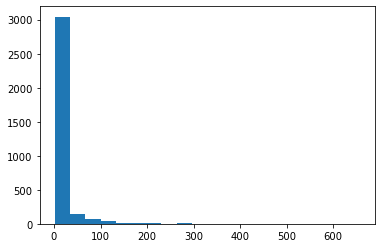

In [253]:
filtered_vocab = vocab[vocab['frequency'] > 1]
plt.hist(filtered_vocab['frequency'], bins=20)
plt.show()

In [254]:
print('Max words in vocabulary: {}'.format(max_words))
print('Max sequence length: {}'.format(max_len))
print('\n')

print('Words allowed in vocabulary: {}'.format(num_words))
print('Allowed sequence length: {}'.format(num_len))
print('\n')

print('Example processed review:')
print(review_samples['review_processed'].iloc[0])
print('\n')

print('Example tokenized review:')
print(review_tokens[0])

Max words in vocabulary: 6053
Max sequence length: 977


Words allowed in vocabulary: 4000
Allowed sequence length: 512


Example processed review:
works pissa


Example tokenized review:
[ 222 3343    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0 

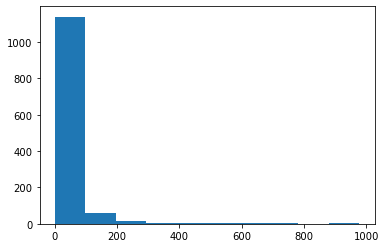

In [255]:
seq_len = [len(x) for x in sequences]
d = {'sequence': sequences, 'length': seq_len}
seqs = pd.DataFrame(data = d)

plt.hist(seqs['length'])
plt.show()

In [256]:
seqs[seqs['length'] > 512]

,sequence,length
21,"[1462, 3361, 162, 207, 104, 451, 6, 3362, 974,...",838
69,"[3461, 79, 291, 1187, 91, 181, 1500, 15, 41, 7...",616
157,"[663, 3662, 602, 3663, 25, 9, 1365, 3, 941, 53...",977
395,"[2835, 1891, 135, 582, 2836, 2837, 582, 217, 2...",951
618,"[55, 335, 23, 47, 16, 18, 279, 393, 21, 937, 5...",749
666,"[257, 1224, 577, 2313, 40, 279, 53, 130, 52, 1...",701
682,"[2835, 1891, 135, 582, 2836, 2837, 582, 217, 2...",951
793,"[280, 3097, 274, 181, 1, 47, 36, 221, 181, 15,...",585
930,"[280, 3097, 1, 1024, 16, 40, 36, 805, 868, 102...",897
1086,"[352, 103, 868, 55, 17, 642, 40, 1454, 9, 168,...",652


### X.X Bi-directional LSTM

In [257]:
# Set model hyperparamters
output_dim = 256
epochs = 10
batch_size = 512
dropout_rate = 0.0
num_classes = len(np.unique(labels, axis=0))
opt = tf.keras.optimizers.Adam(learning_rate=0.001,
                               epsilon=0.00000001,
                               clipnorm=1.0
                              )
loss_func = 'binary_crossentropy'
metrics = ['accuracy']

In [285]:
# Create usefulness target variable as categorical
labels = review_samples['useful']
labels = tf.keras.utils.to_categorical(labels, num_classes=2, dtype="float32")

In [286]:
# Split data into train, dev, and test sets
X_train, X_test, y_train, y_test = train_test_split(review_tokens, labels, test_size=0.2, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

In [259]:
y_test.shape

(248, 2)

In [260]:
# Build model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=num_words, output_dim=output_dim, input_length=num_len))
lstm_model.add(Bidirectional(LSTM(64, dropout=dropout_rate)))
lstm_model.add(Dense(2, activation='softmax'))
lstm_model.compile(optimizer=opt, loss=loss_func, metrics=metrics)
lstm_model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 512, 256)          1024000   
                                                                 
 bidirectional_15 (Bidirecti  (None, 128)              164352    
 onal)                                                           
                                                                 
 dense_37 (Dense)            (None, 2)                 258       
                                                                 
Total params: 1,188,610
Trainable params: 1,188,610
Non-trainable params: 0
_________________________________________________________________


In [288]:
# Fit model
lstm_model.fit(X_train,
               y_train,
               validation_data=(X_dev, y_dev),
               epochs=epochs,
               batch_size=batch_size,
               verbose=2
              )

Epoch 1/10
2/2 - 14s - loss: 0.1322 - accuracy: 0.9542 - val_loss: 1.0691 - val_accuracy: 0.6008 - 14s/epoch - 7s/step
Epoch 2/10
2/2 - 13s - loss: 0.1231 - accuracy: 0.9650 - val_loss: 1.0679 - val_accuracy: 0.6008 - 13s/epoch - 7s/step
Epoch 3/10
2/2 - 13s - loss: 0.1182 - accuracy: 0.9730 - val_loss: 1.0975 - val_accuracy: 0.6008 - 13s/epoch - 7s/step
Epoch 4/10
2/2 - 13s - loss: 0.1082 - accuracy: 0.9717 - val_loss: 1.1554 - val_accuracy: 0.5968 - 13s/epoch - 7s/step
Epoch 5/10
2/2 - 14s - loss: 0.0987 - accuracy: 0.9677 - val_loss: 1.2143 - val_accuracy: 0.6008 - 14s/epoch - 7s/step
Epoch 6/10
2/2 - 15s - loss: 0.0907 - accuracy: 0.9717 - val_loss: 1.2924 - val_accuracy: 0.5968 - 15s/epoch - 7s/step
Epoch 7/10
2/2 - 14s - loss: 0.0913 - accuracy: 0.9690 - val_loss: 1.3298 - val_accuracy: 0.6008 - 14s/epoch - 7s/step
Epoch 8/10
2/2 - 13s - loss: 0.0810 - accuracy: 0.9730 - val_loss: 1.3368 - val_accuracy: 0.6089 - 13s/epoch - 7s/step
Epoch 9/10
2/2 - 13s - loss: 0.0826 - accuracy: 

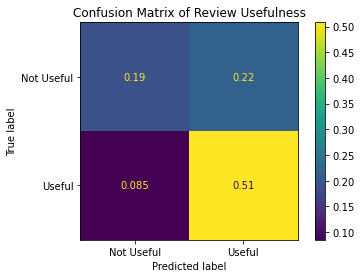

In [262]:
# Plot confusion matrix of training data
y_true = y_train.argmax(axis=1)
y_pred = np.argmax(lstm_model.predict(X_train), axis=1)

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

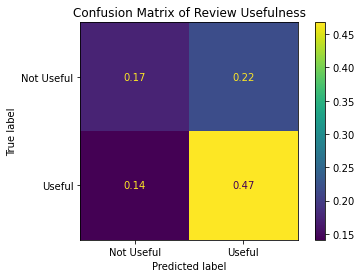

In [263]:
# Plot confusion matrix of test data
y_true = y_test.argmax(axis=1)
y_pred = np.argmax(lstm_model.predict(X_test), axis=1)

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

In [264]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.44      0.49        97
           1       0.68      0.77      0.72       151

    accuracy                           0.64       248
   macro avg       0.62      0.61      0.61       248
weighted avg       0.63      0.64      0.63       248



In [265]:
# Evaluate model
loss, acc = lstm_model.evaluate(X_test, y_test, verbose=1)
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print("Model performance metrics on test data")
print("Accuracy: {:.4f}\nLoss: {:.4f}\nPrecision: {:.4f}\nRecall: {:.4f}\nF1-score: {:.4f}".format(acc, loss, precision, recall, f1))

8/8 [==============================] - 1s 157ms/step - loss: 0.6685 - accuracy: 0.6411
Model performance metrics on test data
Accuracy: 0.6411
Loss: 0.6685
Precision: 0.6311
Recall: 0.6411
F1-score: 0.6323


In [266]:
example0 = "Golf tips magazine is one of the most aptly titled magazines available today. \
            It is chock full of heavily-illustrated exercises and other tips for serious golfers to improve their games.\
            \nThere are a number of golf magazines on the newstand today. Most of them rely on a lifestyle format relying \
            more heavily on lifestyle-type stories about today's hot golfers and the courses they play. Most of them include \
            a brief game tip or two but seem aimed at the casual duffer.\nGolf Tips, on the other hand, features almost nothing \
            but heavily illustrated tips on improving one's swing, eliminating mistakes and putting better. It also is heavily \
            loaded with features on the latest equipment technology. Each issue also seems to feature an article on the technical \
            aspects of a selected major golf course. The articles are written with terminology that serious golfers will understand \
            but that may confuse the weekend player. Judging by the amount of advertising in its early issues, this magazine also \
            appears to be financially healthy.\nIf a reader wants to read about the PGA Tour's superstars, this magazine is not for \
            him/her. But if s/he plans to be one of those superstars, Golf Tips is a good match."

example1 = "The information is interesting and fun, the writing is superb, and the writers and editors have a great sense of humor. \
            I just wish it came out more often!"

example2 = "this data science article is the best ever"

example3 = "i really loved how the technician helped me with the issue that i had"

example4 = "useless comment"

examples = [example0, example1, example2, example3, example4]

In [267]:
def test_examples(model, examples, num_len=512):
    for idx, example in enumerate(examples):
        sequence = tokenizer.texts_to_sequences([example])
        test = pad_sequences(sequence, maxlen=num_len)
        prediction = sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]
        print(idx, ":", prediction)
    
test_examples(lstm_model, examples)

0 : Not Useful
1 : Not Useful
2 : Not Useful
3 : Not Useful
4 : Not Useful


### X.X Convolutional neural network

In [268]:
# # Change data type for usefulness target variable from float to int
y_train = np.array([list(i).index(max(i)) for i in y_train])
y_dev = np.array([list(i).index(max(i)) for i in y_dev])
y_test = np.array([list(i).index(max(i)) for i in y_test])

# labels = review_samples['useful'].astype(int)
# X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.2, random_state=0)
# X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

In [269]:
y_test.shape

(248,)

In [270]:
# Build model
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=num_words, output_dim=output_dim, input_length=num_len))
cnn_model.add(Conv1D(32, 3, padding='same', activation='relu'))
cnn_model.add(MaxPooling1D())
cnn_model.add(Flatten())
cnn_model.add(Dense(250, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(optimizer=opt, loss=loss_func, metrics=metrics)
cnn_model.summary()


Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 512, 256)          1024000   
                                                                 
 conv1d_9 (Conv1D)           (None, 512, 32)           24608     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 256, 32)          0         
 1D)                                                             
                                                                 
 flatten_9 (Flatten)         (None, 8192)              0         
                                                                 
 dense_38 (Dense)            (None, 250)               2048250   
                                                                 
 dense_39 (Dense)            (None, 1)                 251       
                                                     

In [283]:
# Fit model
cnn_model.fit(X_train,
              y_train,
              validation_data=(X_dev, y_dev),
              epochs=epochs,
              batch_size=batch_size,
              verbose=2
             )

Epoch 1/10
2/2 - 2s - loss: 0.0769 - accuracy: 0.9744 - val_loss: 1.0996 - val_accuracy: 0.6532 - 2s/epoch - 778ms/step
Epoch 2/10
2/2 - 2s - loss: 0.0587 - accuracy: 0.9879 - val_loss: 1.0946 - val_accuracy: 0.6492 - 2s/epoch - 879ms/step
Epoch 3/10
2/2 - 2s - loss: 0.0541 - accuracy: 0.9825 - val_loss: 1.3227 - val_accuracy: 0.6089 - 2s/epoch - 895ms/step
Epoch 4/10
2/2 - 2s - loss: 0.0517 - accuracy: 0.9852 - val_loss: 1.2668 - val_accuracy: 0.6573 - 2s/epoch - 868ms/step
Epoch 5/10
2/2 - 2s - loss: 0.0489 - accuracy: 0.9892 - val_loss: 1.2832 - val_accuracy: 0.6452 - 2s/epoch - 921ms/step
Epoch 6/10
2/2 - 2s - loss: 0.0380 - accuracy: 0.9879 - val_loss: 1.5562 - val_accuracy: 0.5927 - 2s/epoch - 972ms/step
Epoch 7/10
2/2 - 2s - loss: 0.0449 - accuracy: 0.9838 - val_loss: 1.4280 - val_accuracy: 0.6411 - 2s/epoch - 956ms/step
Epoch 8/10
2/2 - 2s - loss: 0.0350 - accuracy: 0.9892 - val_loss: 1.3877 - val_accuracy: 0.6371 - 2s/epoch - 946ms/step
Epoch 9/10
2/2 - 2s - loss: 0.0346 - acc

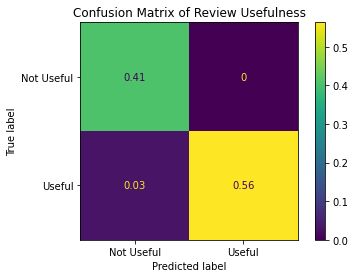

In [280]:
# Plot confusion matrix on training data
y_true = y_train
y_pred = (cnn_model.predict(X_train) >= 0.5).astype("int32")

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

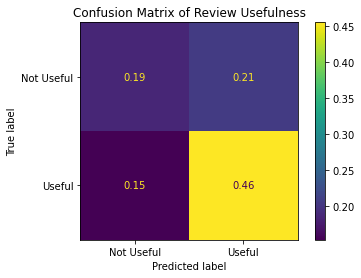

In [281]:
# Plot confusion matrix
y_true = y_test
y_pred = (cnn_model.predict(X_test) >= 0.5).astype("int32")

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

In [282]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.47      0.51        97
           1       0.69      0.75      0.72       151

    accuracy                           0.64       248
   macro avg       0.62      0.61      0.61       248
weighted avg       0.63      0.64      0.64       248



In [278]:
# Evaluate model
loss, acc = cnn_model.evaluate(X_test, y_test, verbose=1)
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print("Model performance metrics on test data")
print("Accuracy: {:.4f}\nLoss: {:.4f}\nPrecision: {:.4f}\nRecall: {:.4f}\nF1-score: {:.4f}".format(acc, loss, precision, recall, f1))

8/8 [==============================] - 0s 14ms/step - loss: 0.6975 - accuracy: 0.6210
Model performance metrics on test data
Accuracy: 0.6210
Loss: 0.6975
Precision: 0.8447
Recall: 0.8140
F1-score: 0.8018


In [222]:
test_examples(cnn_model, examples)

0 : Not Useful
1 : Not Useful
2 : Not Useful
3 : Not Useful
4 : Not Useful


### X.X BERT

[TF BERT Tutorial](https://www.tensorflow.org/text/tutorials/classify_text_with_bert)

In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

In [ ]:
!pip install -q tf-models-official==2.7.0

In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

tf.get_logger().setLevel('ERROR')

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

In [ ]:
reviews = review_samples['review_processed'].fillna('no review')
labels = review_samples['useful'].astype(int)

X, y = reviews, labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

In [ ]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [ ]:
text_test = ['this is such an amazing movie!']
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
loss_func = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
epochs = 5
steps_per_epoch = len(X_train)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss_func,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=X_train,
                               y=y_train,
                               validation_data=(X_dev, y_dev),
                               epochs=epochs)

In [ ]:
# Plot confusion matrix
y_true = y_test
y_pred = (classifier_model.predict(X_test) >= 0.5).astype("int32")

ConfusionMatrixDisplay.from_predictions(y_true,
                                        y_pred,
                                        normalize='all',
                                        display_labels=sentiment
                                       )

plt.title("Confusion Matrix of Review Usefulness")
plt.show()

In [ ]:
# Evaluate model
loss, accuracy = classifier_model.evaluate(X_test, y_test)
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print("Model performance metrics on test data")
print("Accuracy: {:.4f}\nLoss: {:.4f}\nPrecision: {:.4f}\nRecall: {:.4f}\nF1-score: {:.4f}".format(acc, loss, precision, recall, f1))

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## X.X Explanation transfer learning

In [ ]:
# from transformers.models.t5 import T5Model
from transformers import TFT5Model

In [ ]:
model_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "max_seq_length": 128,
    "train_batch_size": 8,
    "num_train_epochs": 1,
    "save_eval_checkpoints": True,
    "save_steps": -1,
    "use_multiprocessing": False,
    "evaluate_during_training": True,
    "evaluate_during_training_steps": 15000,
    "evaluate_during_training_verbose": True,
    "fp16": False,

    "wandb_project": "Question Generation with T5",
}

model = TFT5Model.from_pretrained("t5-small")

### X.X Pre-trained sentiment span extraction model

https://huggingface.co/mrm8488/t5-base-finetuned-span-sentiment-extraction

In [ ]:
example = review_samples.iloc[2]['reviewText']

In [ ]:
from transformers import AutoModelWithLMHead, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-span-sentiment-extraction")
model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-span-sentiment-extraction")

def get_sentiment_span(text):
    input_ids = tokenizer.encode(text, return_tensors="pt", add_special_tokens=True)  # Batch size 1

    generated_ids = model.generate(input_ids=input_ids, num_beams=1, max_length=80).squeeze()

    predicted_span = tokenizer.decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)

    return predicted_span
  
get_sentiment_span("question: negative context: My bike was put on hold...should have known that.... argh total bummer")

# output: 'argh total bummer'

get_sentiment_span("question: positive context: On the monday, so i wont be able to be with you! i love you")

# output: 'i love you'

In [ ]:
get_sentiment_span("question: negative context: {}".format(example))

In [ ]:
review_samples.iloc[2]['reviewText']